# Projet Datascientest - Compagnon immo

mar25_bds_compagnon_immo_1


---

## Modélisation prix de vente au m²- v2.0
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip
import time

# sklearn
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report

from xgboost import XGBRegressor

import joblib

pd.set_option('display.max_columns', None)

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> Pour la prédiction des prix au m², nous gardons que la dernière année.
</div>

### Chargement de données
---

In [3]:
output_path_2024 = '../data/raw/full_2024_merged.csv.gz'

if os.path.exists(output_path_2024):
    with gzip.open(output_path_2024, 'rt', encoding='utf-8') as file:
        print("Le fichier existe déjà. Chargement du dataFrame...")
        df_2024 = pd.read_csv(file, low_memory=False, index_col="id_mutation")
        print("DataFrame chargé.")
else:
    print("Création du dataframe pour 2024...")
    output_path = f"../data/raw/full_years_merged.csv.gz"
    dvf_df = pd.read_csv(output_path, low_memory=False, index_col="id_mutation")
    
    dvf_df['annee'] = pd.to_datetime(dvf_df['date_mutation']).dt.year
    df_2024 = dvf_df[dvf_df['annee'] == 2024]

    df_2024.to_csv(output_path_2024, compression='gzip')
    print("Création du dataframe pour 2024 terminé")

Le fichier existe déjà. Chargement du dataFrame...
DataFrame chargé.


In [4]:
display(df_2024.head())

display(df_2024.shape)

,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,prix_m2_vente,annee
id_mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-1,2024-01-02,1,Vente,346.5,NaN,NaN,LE DELIVRE,B020,1230.0,01076,Chaley,01,NaN,NaN,010760000B0514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,P,prés,NaN,NaN,99.0,5.530952,45.952439,NaN,2024
2024-2,2024-01-03,2,Vente,10000.0,NaN,NaN,CHEVRY DESSOUS,B007,1170.0,01103,Chevry,01,NaN,NaN,011030000B1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,S,sols,NaN,NaN,115.0,6.043339,46.282256,NaN,2024
2024-3,2024-01-08,1,Vente,249000.0,NaN,NaN,PIN HAMEAU,B086,1290.0,01203,Laiz,01,NaN,NaN,012030000C1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,S,sols,NaN,NaN,497.0,4.911143,46.247235,NaN,2024
2024-4,2024-01-03,1,Vente,329500.0,9001.0,NaN,PL DU JURA,0500,1170.0,01173,Gex,01,NaN,NaN,01173000AI0551,NaN,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,6.058695,46.332212,NaN,2024
2024-4,2024-01-03,1,Vente,329500.0,29.0,NaN,PL DU JURA,0500,1170.0,01173,Gex,01,NaN,NaN,01173000AI0551,NaN,NaN,175,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,6.058695,46.332212,NaN,2024


(3458643, 41)

### Nettoyage et pre-processing des données

> Création de la target prix_m2_vente

In [177]:
# On supprime les valeurs foncières manquantes et les surfaces à 0.
df_2024 = df_2024.dropna(subset=['valeur_fonciere'])
df_2024 = df_2024[(df_2024['surface_reelle_bati'].notna()) | (df_2024['surface_terrain'].notna())]
# Evite les divisions par 0
df_2024 = df_2024[(df_2024['surface_reelle_bati'] > 0) | (df_2024['surface_terrain'] > 0)]

In [178]:
# surface_reelle_bati renseigné
df_2024 = df_2024.copy()

# surface_reelle_bati renseigné
df_2024['prix_m2_vente'] = np.where(
    (df_2024['surface_reelle_bati'].notna()) & (df_2024['surface_reelle_bati'] > 0),  
    df_2024['valeur_fonciere'] / df_2024['surface_reelle_bati'],
    # surface_terrain renseigné
    np.where(
        (df_2024['surface_terrain'].notna()) & (df_2024['surface_terrain'] > 0),
        df_2024['valeur_fonciere'] / df_2024['surface_terrain'],
        np.nan
    )
)

print('Target manquante : ', df_2024['prix_m2_vente'].isna().sum())

Target manquante :  0


> Suppression des doublons

In [181]:
print(f"% de doublons {df_2024.duplicated().sum() / len(df_2024) * 100:.2f}")
df_2024 = df_2024.drop_duplicates()

% de doublons 7.71


> Supression des colonnes non pertinentes 

In [182]:
df_2024 = df_2024.drop(['ancien_code_commune',
                      'ancien_nom_commune',
                      'ancien_id_parcelle',
                      'id_parcelle',
                      'numero_volume',
                      'adresse_suffixe',
                      'adresse_numero',
                      'adresse_nom_voie',
                      'adresse_code_voie'], axis=1)

### Feature engineering

> Gestion des dates

In [183]:
df_2024['date_mutation'] = pd.to_datetime(df_2024['date_mutation'], format='%Y-%m-%d')
df_2024['annee'] = df_2024['date_mutation'].dt.year
df_2024['mois'] = df_2024['date_mutation'].dt.month
df_2024 = df_2024.drop('date_mutation', axis=1)

> Informations INSEE

In [187]:
# Infos adresses (récupération depuis dataset insee)
url_insee = 'https://raw.githubusercontent.com/klopstock-dviz/immo_vis/master/data/codesPostaux_communesINSEE.csv'
df_insee = pd.read_csv(url_insee, sep=';')
df_insee.head(3)

,Code_commune_INSEE,Nom_commune,Code_postal,Ligne_5,Libellé_d_acheminement,coordonnees_gps
0,01011,APREMONT,1100,NaN,APREMONT,"46.2054981558,5.65781475272"
1,01021,ARS SUR FORMANS,1480,NaN,ARS SUR FORMANS,"45.9934611,4.82199649494"
2,01028,BANEINS,1990,NaN,BANEINS,"46.1141214445,4.90146475101"


In [188]:
df_insee[['latitude', 'longitude']] = df_insee['coordonnees_gps'].str.split(',', expand=True)
latitude_dict = df_insee.set_index('Code_commune_INSEE')['latitude'].to_dict()
longitude_dict = df_insee.set_index('Code_commune_INSEE')['longitude'].to_dict()

df_2024['latitude'] = df_2024['latitude'].fillna(df_2024['code_commune'].map(latitude_dict)).astype('float')
df_2024['longitude'] = df_2024['longitude'].fillna(df_2024['code_commune'].map(longitude_dict)).astype('float')
df_2024 = df_2024.dropna(subset=['latitude', 'longitude'])
del df_insee

> Suppression colonnes après traitement

In [191]:
# on garde le code commune (0 manquant et réduit la multicolinéarité)
df_2024 = df_2024.drop('code_postal', axis=1)
# on a déjà le code commune
df_2024 = df_2024.drop('nom_commune', axis=1)
# cas spécifigue pour la Corse
df_2024['code_departement'] = df_2024['code_departement'].replace({'2A': '20', '2B': '20'})

> Gestion des manquants

In [193]:
print(f"Manquants avant traitement : {round((df_2024.isna().sum().sum() / df_2024.size) * 100, 2)}%")

Manquants avant traitement : 47.08%


In [195]:
df_2024.loc[(df_2024['code_type_local'].isna()) & (df_2024['type_local'] == 'Maison'), 'code_type_local'] = 1.0
df_2024.loc[(df_2024['code_type_local'].isna()) & (df_2024['type_local'] == 'Appartement'), 'code_type_local'] = 2.0
df_2024.loc[(df_2024['code_type_local'].isna()) & (df_2024['type_local'] == 'Dépendance'), 'code_type_local'] = 3.0
df_2024.loc[(df_2024['code_type_local'].isna()) & (df_2024['type_local'] == 'Local industriel. commercial ou assimilé'), 'code_type_local'] = 4.0
df_2024.loc[(df_2024['code_type_local'].isna()), 'code_type_local'] = 5.0

df_2024.loc[(df_2024['type_local'].isna()) & (df_2024['code_type_local'] == 1.0), 'type_local'] = 'Maison'
df_2024.loc[(df_2024['type_local'].isna()) & (df_2024['code_type_local'] == 2.0), 'type_local'] = 'Appartement'
df_2024.loc[(df_2024['type_local'].isna()) & (df_2024['code_type_local'] == 3.0), 'type_local'] = 'Dépendance'
df_2024.loc[(df_2024['type_local'].isna()) & (df_2024['code_type_local'] == 4.0), 'type_local'] = 'Local industriel. commercial ou assimilé'
df_2024.loc[(df_2024['type_local'].isna()), 'type_local'] = 'Autre'

df_2024.loc[(df_2024['surface_reelle_bati'].isna()) & (df_2024['code_nature_culture'] != "AB"), 'surface_reelle_bati'] = 0

df_2024.loc[(df_2024['nombre_pieces_principales'].isna()) & (df_2024['code_nature_culture'] != "AB"), 'nombre_pieces_principales'] = 0

df_2024['lot1_surface_carrez'] = df_2024['surface_reelle_bati']

df_2024['code_nature_culture'] = df_2024['code_nature_culture'].fillna('NS')

df_2024['nature_culture'] = df_2024['nature_culture'].fillna('autres')

df_2024['code_nature_culture_speciale'] = df_2024['code_nature_culture_speciale'].fillna('NS')

df_2024['nature_culture_speciale'] = df_2024['nature_culture_speciale'].fillna('Autre')

df_2024['surface_terrain'] = df_2024['surface_terrain'].fillna(0)

df_2024['lot1_surface_carrez'] = df_2024['lot1_surface_carrez'].fillna(0)
df_2024['lot2_surface_carrez'] = df_2024['lot2_surface_carrez'].fillna(0)
df_2024['lot3_surface_carrez'] = df_2024['lot3_surface_carrez'].fillna(0)
df_2024['lot4_surface_carrez'] = df_2024['lot4_surface_carrez'].fillna(0)
df_2024['lot5_surface_carrez'] = df_2024['lot5_surface_carrez'].fillna(0)

df_2024['lot1_numero'] = df_2024['lot1_numero'].fillna(0)
df_2024['lot2_numero'] = df_2024['lot2_numero'].fillna(0)
df_2024['lot3_numero'] = df_2024['lot3_numero'].fillna(0)
df_2024['lot4_numero'] = df_2024['lot4_numero'].fillna(0)
df_2024['lot5_numero'] = df_2024['lot5_numero'].fillna(0)

df_2024['surface_reelle_bati'] = df_2024['surface_reelle_bati'].fillna(0)

df_2024['nombre_pieces_principales'] = df_2024['nombre_pieces_principales'].fillna(0)

df_2024.loc[df_2024['nombre_lots'].isna(), 'nombre_lots'] = 0

In [197]:
# on a les codes correspondants
df_2024 = df_2024.drop(['nature_culture_speciale', 'nature_culture'], axis=1)

In [199]:
print(f"Manquants après traitement : {round((df_2024.isna().sum().sum() / df_2024.size) * 100, 2)}%")

Manquants après traitement : 0.0%


> Gestion valeurs extrêmes / aberrantes

In [201]:
df_2024 = df_2024[(df_2024['prix_m2_vente'] > 10) & (df_2024['prix_m2_vente'] < 10_000_000)]
df_2024 = df_2024[(df_2024['valeur_fonciere'] > 100) & (df_2024['valeur_fonciere'] < 100_000_000)]
df_2024 = df_2024[df_2024['surface_terrain'] < 1_000_000]

### Checkpoint

In [3]:
display(df_2024.shape)
# Dump le dataset clean
output_path = '../data/processed/dvf_data_2024_cleaned.csv.gz'
df_2024.to_csv(output_path, index=False, compression='gzip')
print("Le dataframe nettoyé a été sauvegardé.")

In [5]:
output_path = '../data/processed/dvf_data_2024_cleaned.csv.gz'
df_2024 = pd.read_csv(output_path, low_memory=False)

### Train test Split

In [9]:
X = df_2024.drop(columns=['prix_m2_vente'])
y = df_2024['prix_m2_vente']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Encodage variables catégorielles

In [11]:
print("Nombres de variables catégorielles :", len(X_train.select_dtypes('object').columns))

Nombres de variables catégorielles : 9


> One Hot Encoding

In [13]:
one_hot_cols = ['type_local', 'nature_mutation']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train[one_hot_cols])

X_train_ohe = pd.DataFrame(ohe.transform(X_train[one_hot_cols]), 
                           columns=ohe.get_feature_names_out(one_hot_cols),
                           index=X_train.index)

X_test_ohe = pd.DataFrame(ohe.transform(X_test[one_hot_cols]), 
                          columns=ohe.get_feature_names_out(one_hot_cols),
                          index=X_test.index)

X_train = X_train.drop(columns=one_hot_cols)
X_test = X_test.drop(columns=one_hot_cols)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)

> Frequency encoding

In [15]:
freq_cols = ['code_nature_culture', 'code_nature_culture_speciale', 'code_commune', 'code_departement']

for col in freq_cols:
    freq_encoding = X_train[col].value_counts(normalize=True)

    X_train[col] = X_train[col].map(freq_encoding).fillna(0)
    X_test[col] = X_test[col].map(freq_encoding).fillna(0)

> Binary Encoding

In [17]:
for i in range(1, 6):
    col = f'lot{i}_numero'
    X_train[col] = (X_train[col] != 0).astype(int)
    X_test[col] = (X_test[col] != 0).astype(int)

In [19]:
print("Variables catégorielles restantes :", len(X_train.select_dtypes('object').columns))

Variables catégorielles restantes : 0


### Standardisation / Normalisation

In [21]:
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns, index=X_test.index)

---

## Sans réduction de dimension
---

### Entrainements modèles

In [225]:
# Approche naïve pour commencer
n_estimators = 100
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=n_estimators, learning_rate=0.1)
}

model_scores = []
best_pred = None
best_model_name = None
best_score = float('inf')

start_time = time.time()

for name, model in models.items():
    
    model.fit(X_train, y_train)
   
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
   
    # Dump des modèles entraînés
    joblib.dump(model, f"../models/{name}.pkl")
    
    # Métriques pour train
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Métriques pour test
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)

    model_scores.append({
        "Modèle": name,
        "MAE_Train": mae_train, "MAE_Test": mae_test,
        "RMSE_Train": rmse_train, "RMSE_Test": rmse_test,
        "R²_Train": r2_train, "R²_Test": r2_test
    })

    if mae_test < best_score:
        best_score = mae_test
        best_model_name = name
        best_pred = y_pred_test
        
end_time = time.time()
elapsed_time = end_time - start_time
print("Temps (min) :", round(elapsed_time / 60, 2))
print(f"Meilleur modèle : {best_model_name} avec MAE = {best_score:.2f}")

C:\Users\tabod\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e+14, tolerance: 8.782e+11
  model = cd_fast.enet_coordinate_descent(


Temps (min) : 10.27
Meilleur modèle : RandomForest avec MAE = 142.58


In [227]:
df_scores = pd.DataFrame(model_scores)
df_scores['Ratio_MAE_Test_Train'] = df_scores['MAE_Test'] / df_scores['MAE_Train']
display(df_scores)

,Modèle,MAE_Train,MAE_Test,RMSE_Train,RMSE_Test,R²_Train,R²_Test,Ratio_MAE_Test_Train
0,LinearRegression,7580.869718,7367.813591,65371.252389,58191.826227,0.181351,0.202868,0.971896
1,Ridge,7580.849154,7367.792423,65371.252392,58191.825446,0.181351,0.202868,0.971895
2,Lasso,7580.309918,7367.235078,65371.253913,58191.792474,0.181351,0.202869,0.971891
3,RandomForest,58.983126,142.582656,4572.758073,12141.242044,0.995994,0.965300,2.417347
4,XGBoost,1350.271401,1410.821135,19885.149905,23728.173733,0.924250,0.867464,1.044843


In [229]:
mape = np.mean(np.abs((y_test - best_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 0.43%


---

## Avec réduction de dimension
---

In [239]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_train)

print(f"Variance expliquée : {sum(pca.explained_variance_ratio_):.2f}")

Variance expliquée : 0.96


### Entraînement des modèles

In [241]:
model_pca_scores = []
best_pca_pred = None
best_model__pca_name = None
best_score_pca = float('inf')

start_time = time.time()

models_pca = {
    "LinearRegression_pca": LinearRegression(),
    "Ridge_PCA": Ridge(alpha=1.0),
    "RandomForest_PCA": RandomForestRegressor(n_estimators=100, n_jobs=-1),
    "XGBoost_PCA": XGBRegressor(n_estimators=100, learning_rate=0.1)
}
for name, model in models_pca.items():
    model.fit(X_train, y_train)
    
    y_pred_pca_train = model.predict(X_train)
    y_pred_pca_test = model.predict(X_test)

    # Dump des modèles entraînés
    joblib.dump(model, f"../models/{name}.pkl")

    # Métriques pour train
    mae_train = mean_absolute_error(y_train, y_pred_pca_train)
    mse_train = mean_squared_error(y_train, y_pred_pca_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_pca_train)
    
    # Métriques pour test
    mae_test = mean_absolute_error(y_test, y_pred_pca_test)
    mse_test = mean_squared_error(y_test, y_pred_pca_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_pca_test)

    model_pca_scores.append({
        "Modèle": name,
        "MAE_PCA_Train": mae_train, "MAE_PCA_Test": mae_test,
        "RMSE_PCA_Train": rmse_train, "RMSE_PCA_Test": rmse_test,
        "R²_PCA_Train": r2_train, "R²_PCA_Test": r2_test
    })

    if mae_test < best_score_pca:
        best_score_pca = mae_test
        best_model_pca_name = name
        best_pca_pred = y_pred_pca_test


end_time = time.time()
elapsed_time = end_time - start_time
print("Temps (min) :", round(elapsed_time / 60, 2))
print(f"Meilleur modèle : {best_model_pca_name} avec MAE = {best_score_pca:.2f}")

Temps (min) : 8.05
Meilleur modèle : RandomForest_PCA avec MAE = 140.32


In [244]:
df_pca_scores = pd.DataFrame(model_pca_scores)
df_pca_scores['Ratio_MAE_PCA_Test_Train'] = df_pca_scores['MAE_PCA_Test'] / df_pca_scores['MAE_PCA_Train']
display(df_pca_scores)

,Modèle,MAE_PCA_Train,MAE_PCA_Test,RMSE_PCA_Train,RMSE_PCA_Test,R²_PCA_Train,R²_PCA_Test,Ratio_MAE_PCA_Test_Train
0,LinearRegression_pca,7580.869718,7367.813591,65371.252389,58191.826227,0.181351,0.202868,0.971896
1,Ridge_PCA,7580.849154,7367.792423,65371.252392,58191.825446,0.181351,0.202868,0.971895
2,RandomForest_PCA,60.808224,140.316233,4684.309592,12073.980836,0.995796,0.965683,2.307521
3,XGBoost_PCA,1350.271401,1410.821135,19885.149905,23728.173733,0.924250,0.867464,1.044843


---

## Optimisation
---

#### Essai réduction overfitting RandomForest

In [247]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def randomized_search_rf(X_train, y_train, n_iter=20, cv=3):
    param_distributions = {
        'n_estimators': randint(200, 800),
        'max_depth': randint(5, 30),
        'min_samples_split': randint(5, 30),
        'min_samples_leaf': randint(2, 15),
        'max_features': ['sqrt', 'log2'],
        'max_samples': [0.3, 0.5, 0.7],
        'bootstrap': [True]
    }
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    search = RandomizedSearchCV(
        rf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',
        cv=cv,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)

    print(f"\nMeilleurs hyperparamètres trouvés :\n{search.best_params_}")
    return search.best_estimator_


In [249]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def detect_overfit(model, X_train, y_train, X_test, y_test):
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calcul des métriques
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print(f"--- Résultats ---")
    print(f"MAE Train : {mae_train:.2f}")
    print(f"MAE Test  : {mae_test:.2f}")
    print(f"R² Train  : {r2_train:.4f}")
    print(f"R² Test   : {r2_test:.4f}")
    print(f"Ratio MAE Test/Train : {mae_test / mae_train:.3f}")

    if (mae_test / mae_train > 1.2) or (r2_train - r2_test > 0.1):
        print("Overfitting détecté !")
    else:
        print("Pas d'overfitting détecté.")


Recherche des meilleurs hyperparamètres sur un échantillon d'abord

In [27]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=500_000, random_state=42)

print(f"Taille sous-échantillon : {X_sub.shape}")

param_distributions = {
    'n_estimators': randint(200, 800),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(5, 30),
    'min_samples_leaf': randint(2, 15),
    'max_features': ['sqrt', 'log2'],
    'max_samples': [0.3, 0.5, 0.7],
    'bootstrap': [True]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,  # Plus rapide que cv=5
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_sub, y_sub)


print("Best Score :", -search.best_score_)
print("Best Params :", search.best_params_)

best_rf = RandomForestRegressor(
    **search.best_params_,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)

joblib.dump(best_rf, '../models/best_random_forest.pkl')

print("Meilleur modèle entraîné et sauvegardé !")

Taille sous-échantillon : (500000, 36)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Score : 3978.074485454892
Best Params : {'bootstrap': True, 'max_depth': 28, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_leaf': 7, 'min_samples_split': 25, 'n_estimators': 543}
✅ Modèle final entraîné et sauvegardé !


---

#### Modèles gradients

In [34]:
def display_learning_curve(model, model_name, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, 
        cv=5, 
        scoring='neg_mean_absolute_error', 
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )
    
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Erreur MAE entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Erreur MAE validation")
    plt.title(f"Learning Curve - {model_name}")
    plt.xlabel("Nombre d'échantillons d'entraînement")
    plt.ylabel("MAE")
    plt.legend(loc="best")
    plt.grid()
    plt.show();

In [36]:
def check_overfitting(mae_test, mae_train):
    overfit_ratio = mae_test / mae_train
    if overfit_ratio > 1.5:
        print(f"Overfitting probable détecté ! (Ratio MAE Test/Train = {overfit_ratio:.2f})")
    elif overfit_ratio < 0.7:
        print(f"Underfitting probable détecté ! (Ratio MAE Test/Train = {overfit_ratio:.2f})")
    else:
        print(f"Modèle équilibré (Ratio MAE Test/Train = {overfit_ratio:.2f})")

In [41]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import numpy as np

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, use_early_stopping=False, early_stopping_rounds=50):
    start_time = time.time()
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calcul des métriques
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Affichage des métriques
    print(f"\n[Résultats {model_name}]")
    print(f"Train - MAE: {mae_train:.2f} | RMSE: {rmse_train:.2f} | R²: {r2_train:.4f}")
    print(f"Test  - MAE: {mae_test:.2f} | RMSE: {rmse_test:.2f} | R²: {r2_test:.4f}")

    display_learning_curve(model, model_name, X_train, y_train)

    check_overfitting(mae_test, mae_train)

    # Sauvegarde du modèle
    joblib.dump(model, f"../models/{model_name}.pkl")
    print(f"Modèle {model_name}.pkl sauvegardé")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Temps (min) :", round(elapsed_time / 60, 2))


[Résultats GradientBoosting]
Train - MAE: 970.43 | RMSE: 14165.92 | R²: 0.9616
Test  - MAE: 1041.34 | RMSE: 18702.99 | R²: 0.9177


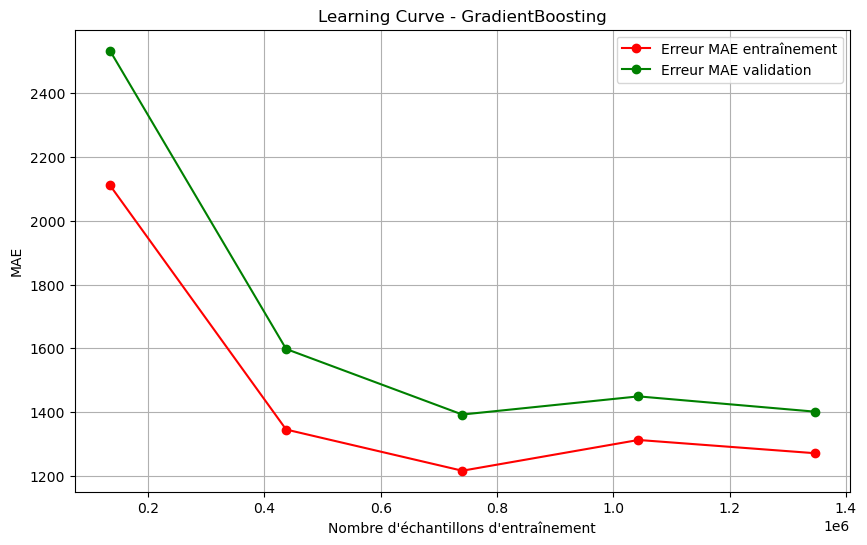

✅ Modèle équilibré (Ratio MAE Test/Train = 1.07)
Modèle GradientBoosting.pkl sauvegardé ✔️

[Résultats XGBoost]
Train - MAE: 1350.27 | RMSE: 19885.15 | R²: 0.9243
Test  - MAE: 1410.82 | RMSE: 23728.17 | R²: 0.8675


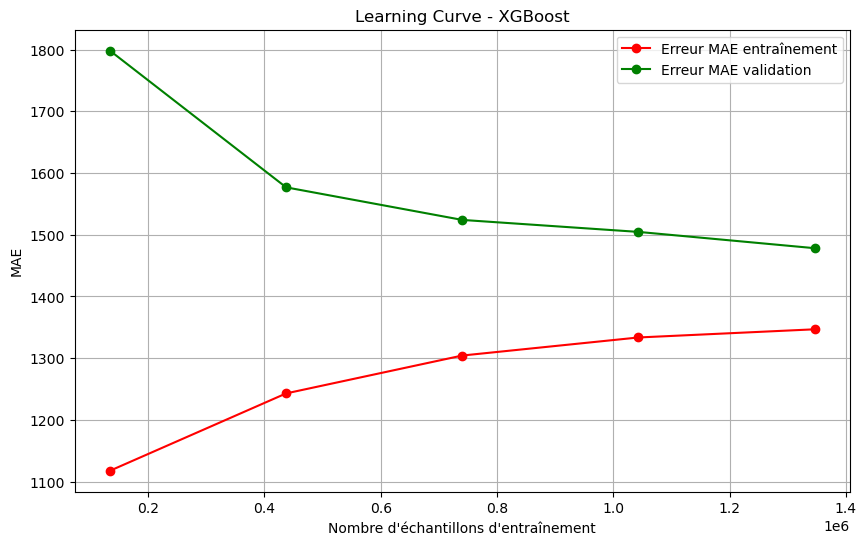

✅ Modèle équilibré (Ratio MAE Test/Train = 1.04)
Modèle XGBoost.pkl sauvegardé ✔️


In [19]:
models = [
    ("GradientBoosting", HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, random_state=42)),
    ("XGBoost", XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
]

for model_name, model in models:
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name)

In [23]:
# Optimisation avec RandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

sample_size = 250000
X_train_sample = X_train.sample(n=sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Définition des paramètres à tester
param_distributions = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'max_features': [None, 'sqrt', 'log2'],
}

# Initialisation du modèle
gb_model = GradientBoostingRegressor(random_state=42)

# Initialisation de RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Lancer le RandomizedSearchCV
random_search.fit(X_train_sample, y_train_sample)

print("Meilleurs paramètres :", random_search.best_params_)
print("Meilleure performance (MAE) :", -random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 300, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.2}
Meilleure performance (MAE) : -0.9338496159307974


In [ ]:
models = [
    ("GradientBoosting", GradientBoostingRegressor(**random_search.best_params_)),
]

for model_name, model in models:
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name)


[Résultats GradientBoosting]
Train - MAE: 549.70 | RMSE: 2818.13 | R²: 0.9985
Test  - MAE: 613.03 | RMSE: 8135.21 | R²: 0.9844


In [17]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Paramètres pour HistGradientBoosting
param_grid_gb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'l2_regularization': [0.1, 0.5, 1.0]
}

# Paramètres pour XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}

# RandomizedSearch pour chaque modèle
models = [
    ("GradientBoosting", HistGradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

for model_name, model in models:
    if model_name == "GradientBoosting":
        random_search = RandomizedSearchCV(model, param_grid_gb, cv=3, scoring='neg_mean_absolute_error', n_iter=25, random_state=42, n_jobs=-1)
    elif model_name == "XGBoost":
        random_search = RandomizedSearchCV(model, param_grid_xgb, cv=3, scoring='neg_mean_absolute_error', n_iter=25, random_state=42, n_jobs=-1)
    
    random_search.fit(X_train, y_train)
    print(f"Meilleurs paramètres pour {model_name} : {random_search.best_params_}")
    print(f"Meilleure performance (MAE) : {-random_search.best_score_:.2f}")

Meilleurs paramètres pour GradientBoosting : {'max_iter': 200, 'max_depth': 7, 'learning_rate': 0.05, 'l2_regularization': 1.0}
Meilleure performance (MAE) : 1345.41
Meilleurs paramètres pour XGBoost : {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}
Meilleure performance (MAE) : 1132.74



[Résultats GradientBoosting]
Train - MAE: 1328.41 | RMSE: 20682.07 | R²: 0.9181
Test  - MAE: 1361.74 | RMSE: 23492.24 | R²: 0.8701


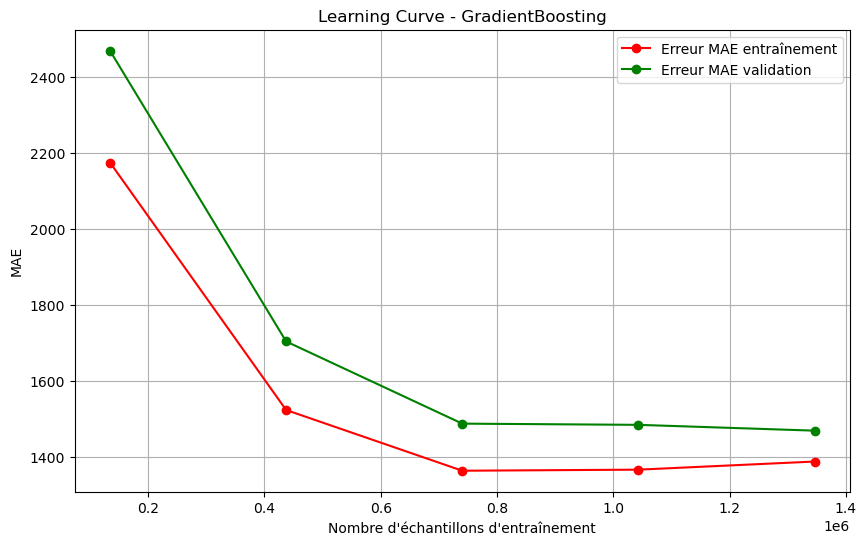

Modèle équilibré (Ratio MAE Test/Train = 1.03)
Modèle GradientBoosting.pkl sauvegardé
Temps (min) : 3.42

[Résultats XGBoost]
Train - MAE: 919.43 | RMSE: 14193.46 | R²: 0.9614
Test  - MAE: 1035.94 | RMSE: 22421.25 | R²: 0.8817


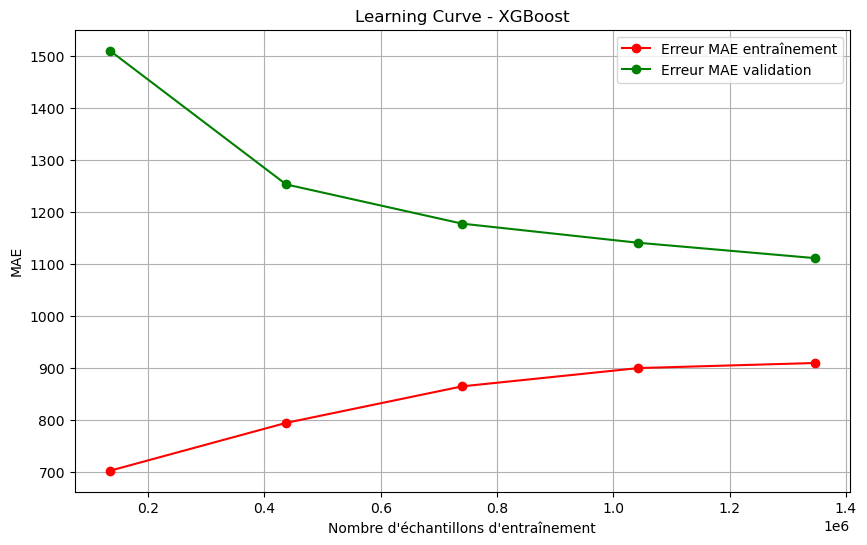

Modèle équilibré (Ratio MAE Test/Train = 1.13)
Modèle XGBoost.pkl sauvegardé
Temps (min) : 1.64


In [23]:
models = [
    ("GradientBoosting", HistGradientBoostingRegressor(max_iter= 200, max_depth= 7, learning_rate= 0.05, l2_regularization= 1.0)),
    ("XGBoost", XGBRegressor(subsample= 0.8, n_estimators= 100, max_depth= 7, learning_rate= 0.1))
]

for model_name, model in models:
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name)

In [33]:
from sklearn.model_selection import GridSearchCV

best_params = {}

param_grid_gb = {
    'max_iter': [180, 200, 220],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.04, 0.05, 0.06],
    'l2_regularization': [0.5, 1.0, 1.5]
}

param_grid_xgb = {
    'n_estimators': [90, 100, 110],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.08, 0.1, 0.12],
    'subsample': [0.75, 0.8, 0.85]
}

for model_name, model in models:
    if model_name == "GradientBoosting":
        grid_search = GridSearchCV(model, param_grid_gb, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    elif model_name == "XGBoost":
        grid_search = GridSearchCV(model, param_grid_xgb, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)

    grid_search.fit(X_train, y_train)

    best_params[model_name] = grid_search.best_params_
    
    print(f"Meilleurs paramètres pour {model_name} : {grid_search.best_params_}")
    print(f"Meilleure performance (MAE) : {-grid_search.best_score_:.2f}")

Meilleurs paramètres pour GradientBoosting : {'l2_regularization': 1.0, 'learning_rate': 0.06, 'max_depth': 7, 'max_iter': 220}
Meilleure performance (MAE) : 1303.44
Meilleurs paramètres pour XGBoost : {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 110, 'subsample': 0.85}
Meilleure performance (MAE) : 925.58


> Evalution avec paramètres GridSearchCV


[Résultats GradientBoosting]
Train - MAE: 1277.31 | RMSE: 20846.10 | R²: 0.9168
Test  - MAE: 1315.79 | RMSE: 23601.48 | R²: 0.8689


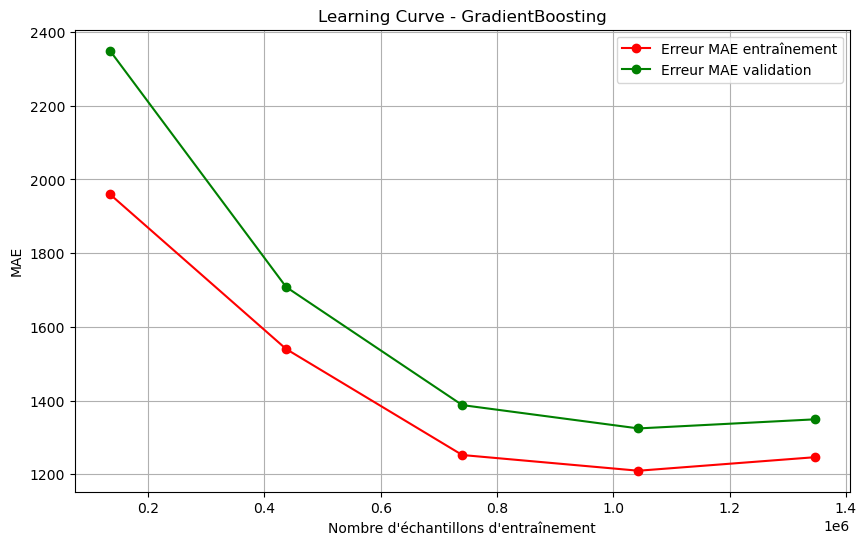

Modèle équilibré (Ratio MAE Test/Train = 1.03)
Modèle GradientBoosting.pkl sauvegardé
Temps (min) : 3.62

[Résultats XGBoost]
Train - MAE: 658.03 | RMSE: 9888.53 | R²: 0.9813
Test  - MAE: 855.00 | RMSE: 23079.86 | R²: 0.8746


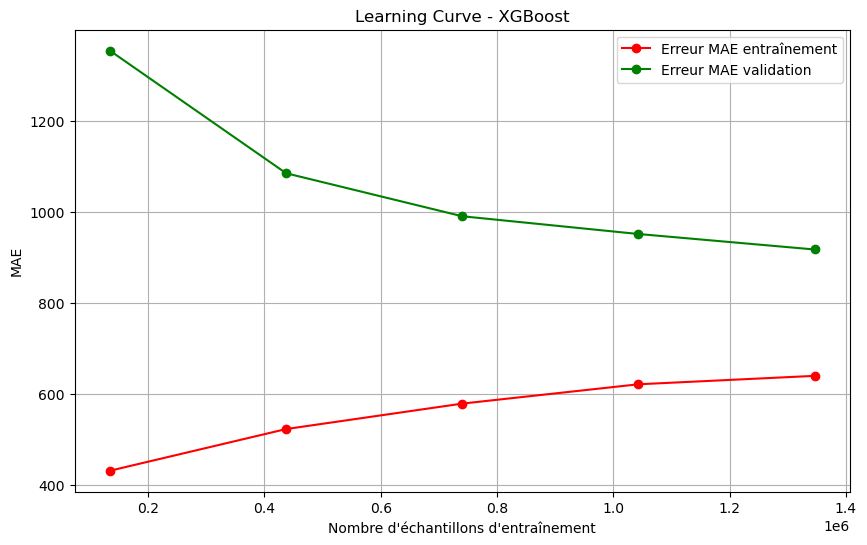

Modèle équilibré (Ratio MAE Test/Train = 1.30)
Modèle XGBoost.pkl sauvegardé
Temps (min) : 1.94


In [44]:
models = [
    ("GradientBoosting", HistGradientBoostingRegressor(**best_params['GradientBoosting'])),
    ("XGBoost", XGBRegressor(**best_params['XGBoost']))
]

for model_name, model in models:
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name)

> Analyse de l'importance des features

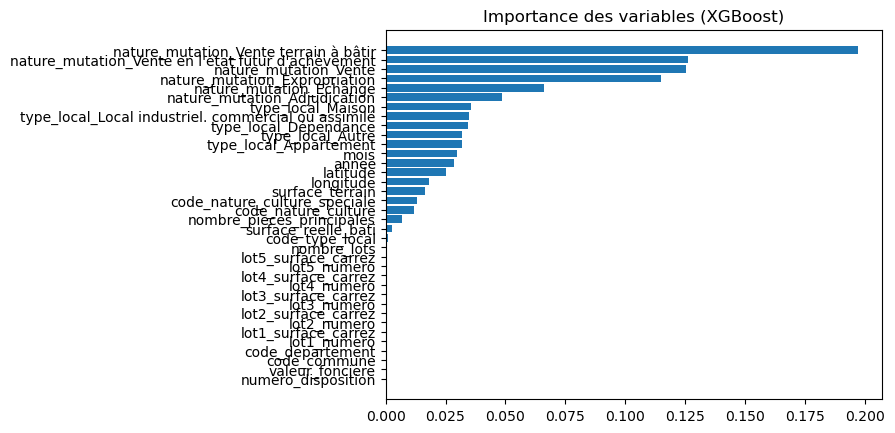

In [53]:
# Importance des features dans XGBoost
feature_importances = sorted(model.feature_importances_)
plt.barh(X_train.columns, feature_importances)
plt.title("Importance des variables (XGBoost)")
plt.show();

> Avec rédution de dimension

n_components 2

[Résultats GradientBoosting]
Train - MAE: 6718.33 | RMSE: 65502.96 | R²: 0.1780
Test  - MAE: 6509.13 | RMSE: 58424.71 | R²: 0.1965


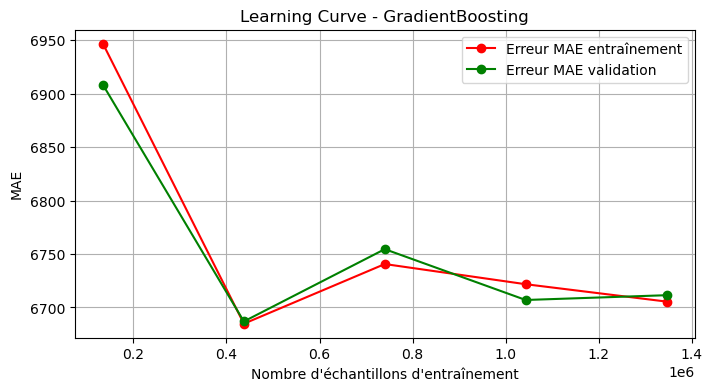

Modèle équilibré (Ratio MAE Test/Train = 0.97)
Modèle GradientBoosting.pkl sauvegardé
Temps (min) : 1.35

[Résultats XGBoost]
Train - MAE: 6634.21 | RMSE: 65849.80 | R²: 0.1693
Test  - MAE: 6444.81 | RMSE: 59081.07 | R²: 0.1783


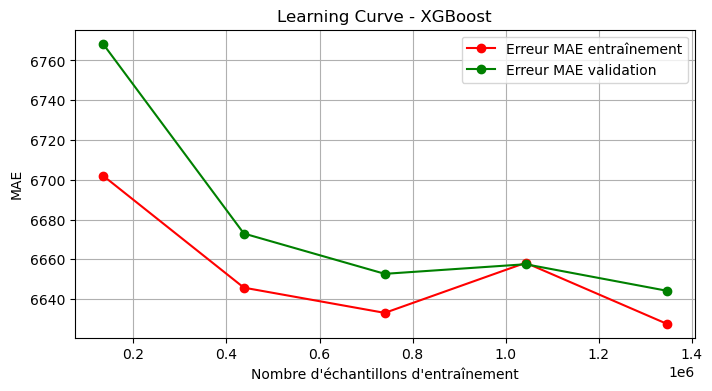

Modèle équilibré (Ratio MAE Test/Train = 0.97)
Modèle XGBoost.pkl sauvegardé
Temps (min) : 1.43
n_components 3

[Résultats GradientBoosting]
Train - MAE: 5150.26 | RMSE: 64256.77 | R²: 0.2090
Test  - MAE: 4991.29 | RMSE: 57521.17 | R²: 0.2211


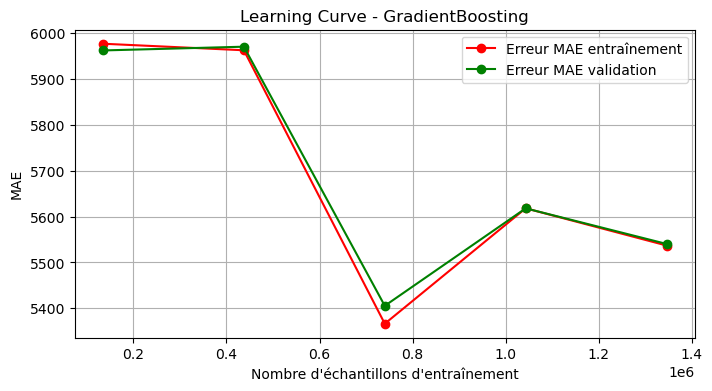

Modèle équilibré (Ratio MAE Test/Train = 0.97)
Modèle GradientBoosting.pkl sauvegardé
Temps (min) : 1.73

[Résultats XGBoost]
Train - MAE: 4952.41 | RMSE: 63929.08 | R²: 0.2171
Test  - MAE: 4819.08 | RMSE: 57272.92 | R²: 0.2278


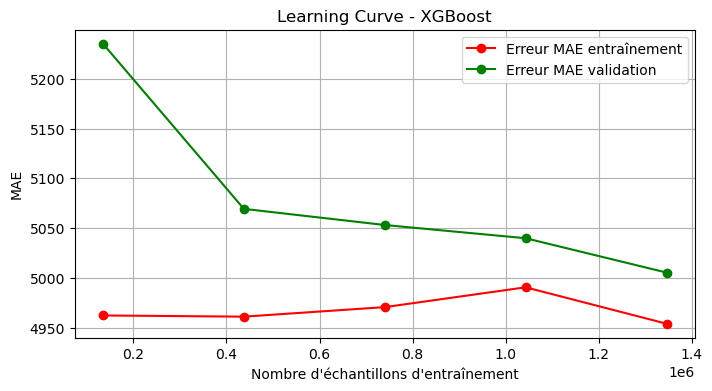

Modèle équilibré (Ratio MAE Test/Train = 0.97)
Modèle XGBoost.pkl sauvegardé
Temps (min) : 1.4
n_components 5

[Résultats GradientBoosting]
Train - MAE: 4369.32 | RMSE: 59007.22 | R²: 0.3330
Test  - MAE: 4248.38 | RMSE: 54346.15 | R²: 0.3047


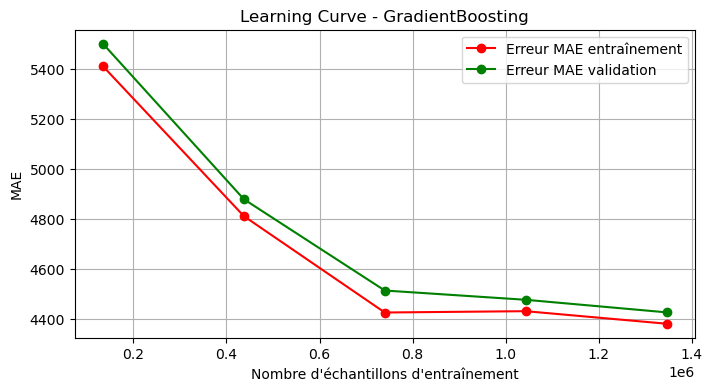

Modèle équilibré (Ratio MAE Test/Train = 0.97)
Modèle GradientBoosting.pkl sauvegardé
Temps (min) : 2.18

[Résultats XGBoost]
Train - MAE: 3856.17 | RMSE: 57732.53 | R²: 0.3615
Test  - MAE: 3802.20 | RMSE: 54122.74 | R²: 0.3104


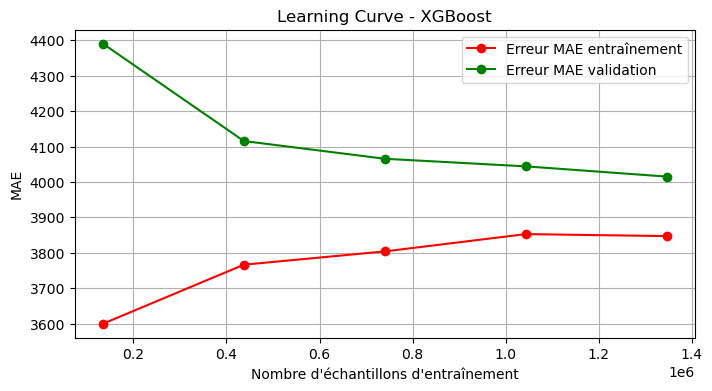

Modèle équilibré (Ratio MAE Test/Train = 0.99)
Modèle XGBoost.pkl sauvegardé
Temps (min) : 1.44
n_components 10

[Résultats GradientBoosting]
Train - MAE: 4031.85 | RMSE: 51062.28 | R²: 0.5005
Test  - MAE: 4008.03 | RMSE: 50111.91 | R²: 0.4089


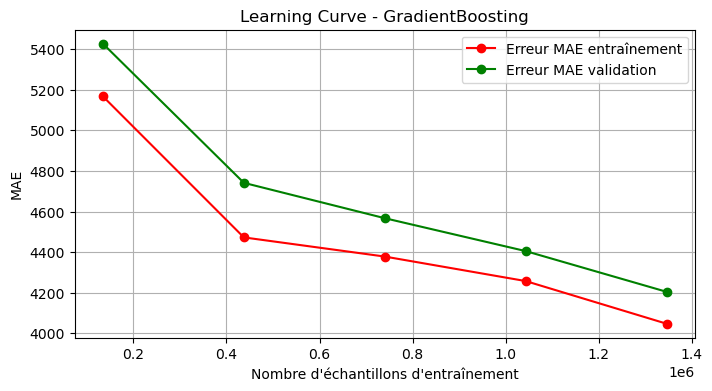

Modèle équilibré (Ratio MAE Test/Train = 0.99)
Modèle GradientBoosting.pkl sauvegardé
Temps (min) : 2.15

[Résultats XGBoost]
Train - MAE: 2943.25 | RMSE: 37132.92 | R²: 0.7359
Test  - MAE: 3258.64 | RMSE: 47842.57 | R²: 0.4612


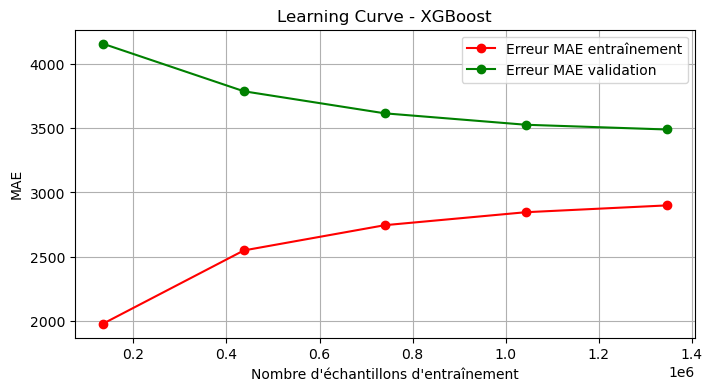

Modèle équilibré (Ratio MAE Test/Train = 1.11)
Modèle XGBoost.pkl sauvegardé
Temps (min) : 1.58
n_components 20

[Résultats GradientBoosting]
Train - MAE: 3627.91 | RMSE: 46576.45 | R²: 0.5844
Test  - MAE: 3704.41 | RMSE: 47716.85 | R²: 0.4640


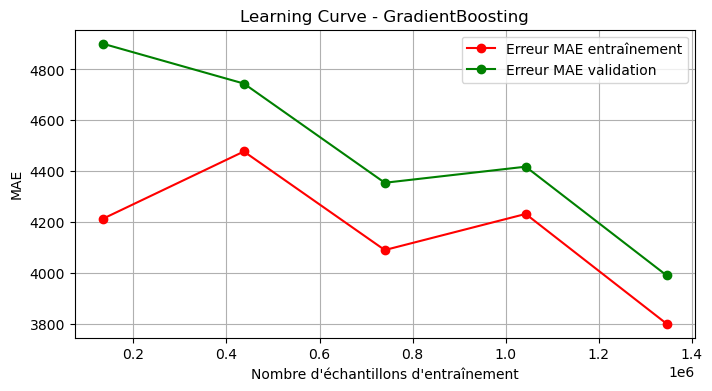

Modèle équilibré (Ratio MAE Test/Train = 1.02)
Modèle GradientBoosting.pkl sauvegardé
Temps (min) : 2.19

[Résultats XGBoost]
Train - MAE: 2514.93 | RMSE: 31169.63 | R²: 0.8139
Test  - MAE: 3001.13 | RMSE: 47541.37 | R²: 0.4680


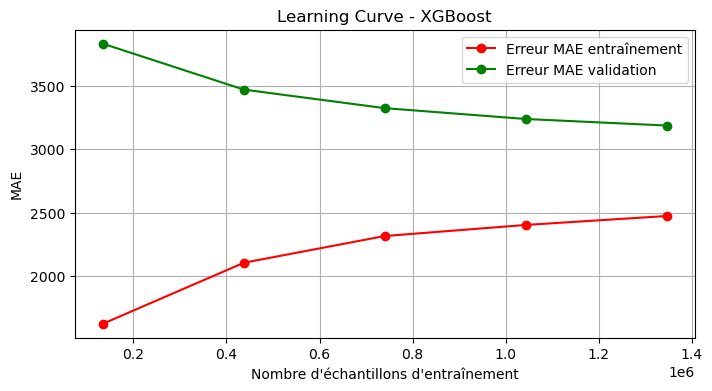

Modèle équilibré (Ratio MAE Test/Train = 1.19)
Modèle XGBoost.pkl sauvegardé
Temps (min) : 1.83
n_components 30

[Résultats GradientBoosting]
Train - MAE: 3671.76 | RMSE: 45179.59 | R²: 0.6090
Test  - MAE: 3744.63 | RMSE: 46872.95 | R²: 0.4828


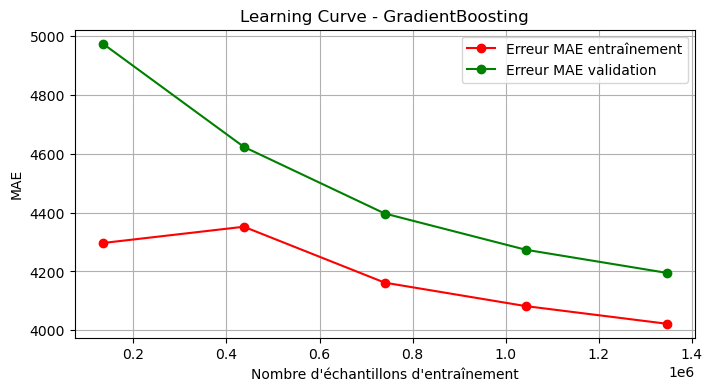

Modèle équilibré (Ratio MAE Test/Train = 1.02)
Modèle GradientBoosting.pkl sauvegardé
Temps (min) : 1.97

[Résultats XGBoost]
Train - MAE: 2418.00 | RMSE: 28407.35 | R²: 0.8454
Test  - MAE: 2938.82 | RMSE: 46992.28 | R²: 0.4802


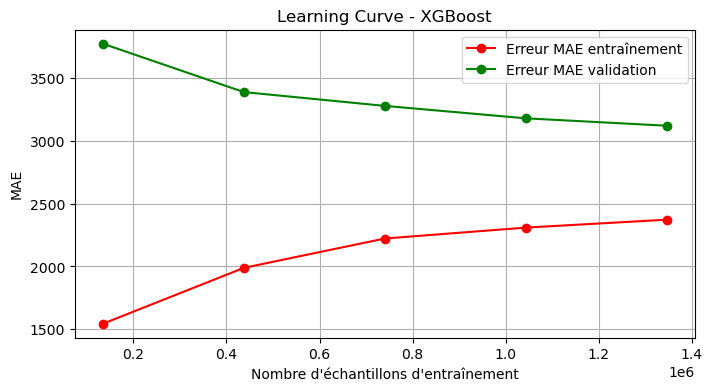

Modèle équilibré (Ratio MAE Test/Train = 1.22)
Modèle XGBoost.pkl sauvegardé
Temps (min) : 2.07
n_components 0.95

[Résultats GradientBoosting]
Train - MAE: 4267.22 | RMSE: 57880.28 | R²: 0.3582
Test  - MAE: 4127.89 | RMSE: 52265.44 | R²: 0.3570


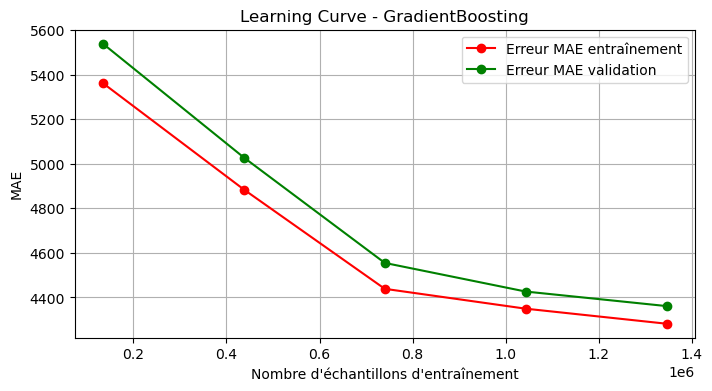

Modèle équilibré (Ratio MAE Test/Train = 0.97)
Modèle GradientBoosting.pkl sauvegardé
Temps (min) : 2.17

[Résultats XGBoost]
Train - MAE: 3512.43 | RMSE: 53054.21 | R²: 0.4608
Test  - MAE: 3537.62 | RMSE: 51072.64 | R²: 0.3860


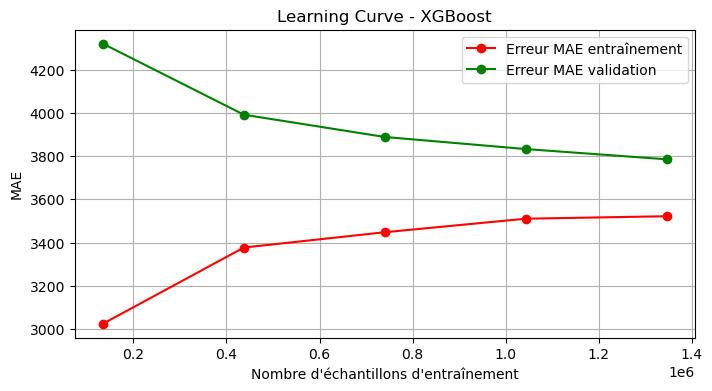

Modèle équilibré (Ratio MAE Test/Train = 1.01)
Modèle XGBoost.pkl sauvegardé
Temps (min) : 1.49


In [42]:
# Evite de relancer le gridSearchCV
best_params = {
    'GradientBoosting': {'l2_regularization': 1.0, 'learning_rate': 0.06, 'max_depth': 7, 'max_iter': 220},
    'XGBoost': {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 110, 'subsample': 0.85}
}
results = []

models = [
    ("GradientBoosting", HistGradientBoostingRegressor(**best_params['GradientBoosting'])),
    ("XGBoost", XGBRegressor(**best_params['XGBoost']))
]

n_components_list = [2, 3, 5, 10, 20, 30, 0.95]

for n_components in n_components_list:
    print('n_components', n_components)
    for model_name, model in models:

        pca = PCA(n_components=n_components)

        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        train_and_evaluate_model(model, X_train_pca, y_train, X_test_pca, y_test, model_name)

> Méthode de sélection de features


[Résultats GradientBoosting]
Train - MAE: 5625.42 | RMSE: 54176.94 | R²: 0.4377
Test  - MAE: 5591.44 | RMSE: 49622.61 | R²: 0.4204


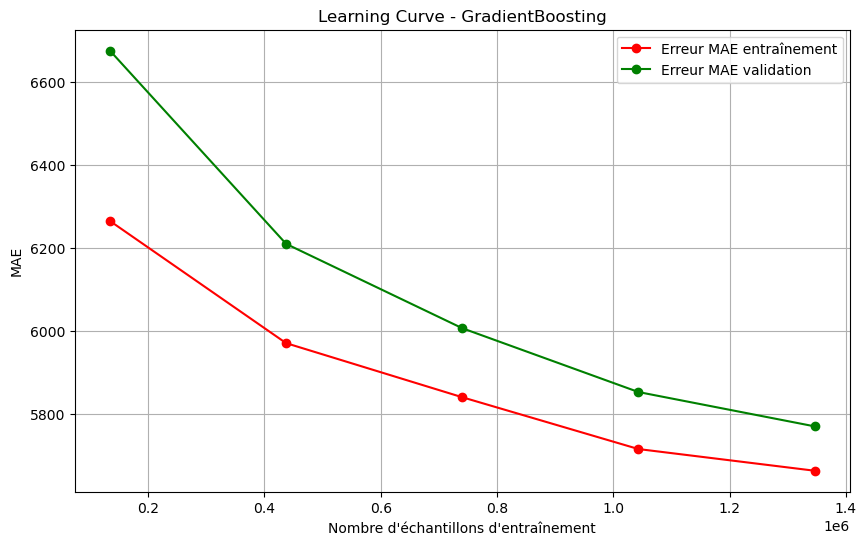

Modèle équilibré (Ratio MAE Test/Train = 0.99)
Modèle GradientBoosting.pkl sauvegardé
Temps (min) : 3.8

[Résultats XGBoost]
Train - MAE: 4821.20 | RMSE: 42450.29 | R²: 0.6548
Test  - MAE: 5063.76 | RMSE: 46696.27 | R²: 0.4867


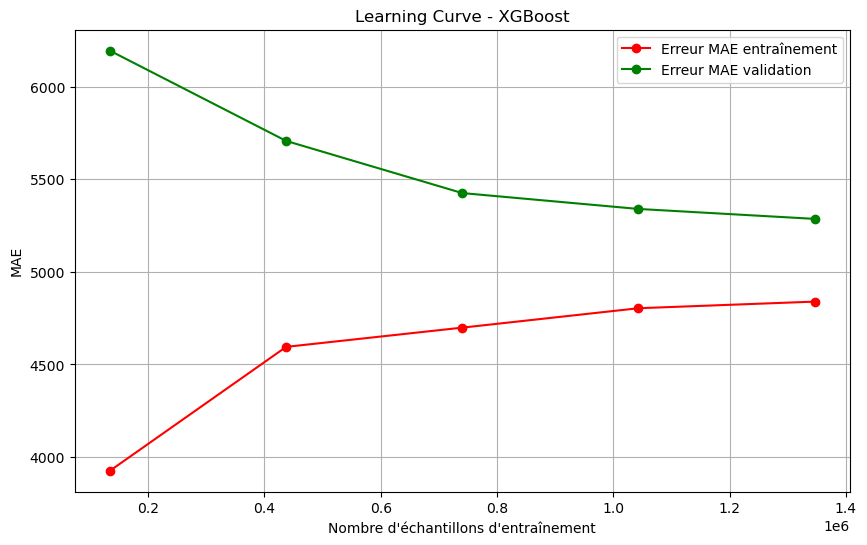

Modèle équilibré (Ratio MAE Test/Train = 1.05)
Modèle XGBoost.pkl sauvegardé
Temps (min) : 2.03


In [95]:
columns = X_train.columns
feature_importances_series = pd.Series(feature_importances, index=columns)
selected_columns = feature_importances_series[feature_importances_series != 0].index.tolist()

X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

models = [
    ("GradientBoosting", HistGradientBoostingRegressor(**best_params['GradientBoosting'])),
    ("XGBoost", XGBRegressor(**best_params['XGBoost']))
]

for model_name, model in models:
    train_and_evaluate_model(model, X_train_selected, y_train, X_test_selected, y_test, model_name)

> Bagging et Stacking


[Résultats bagging]
Train - MAE: 659.18 | RMSE: 13685.79 | R²: 0.9641
Test  - MAE: 811.85 | RMSE: 22966.10 | R²: 0.8758


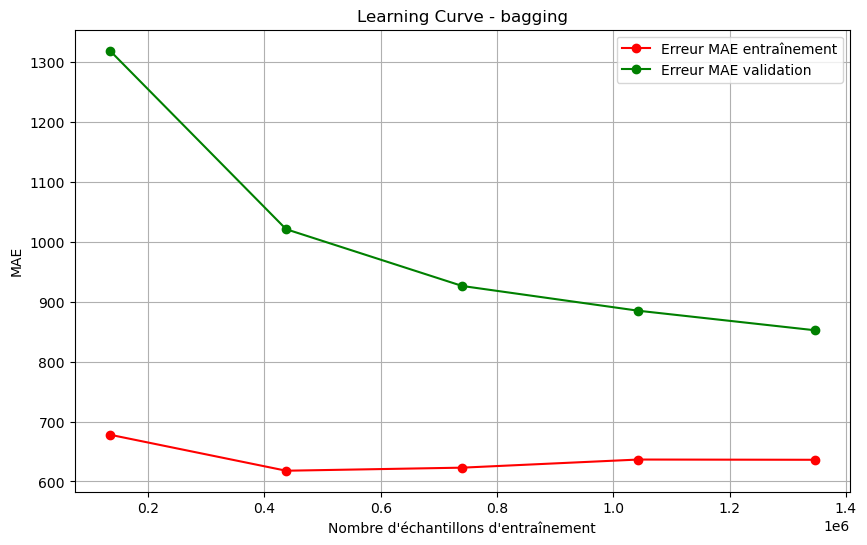

Modèle équilibré (Ratio MAE Test/Train = 1.23)
Modèle bagging.pkl sauvegardé
Temps (min) : 19.8

[Résultats stacking]
Train - MAE: 869.30 | RMSE: 13543.81 | R²: 0.9649
Test  - MAE: 973.76 | RMSE: 20361.14 | R²: 0.9024


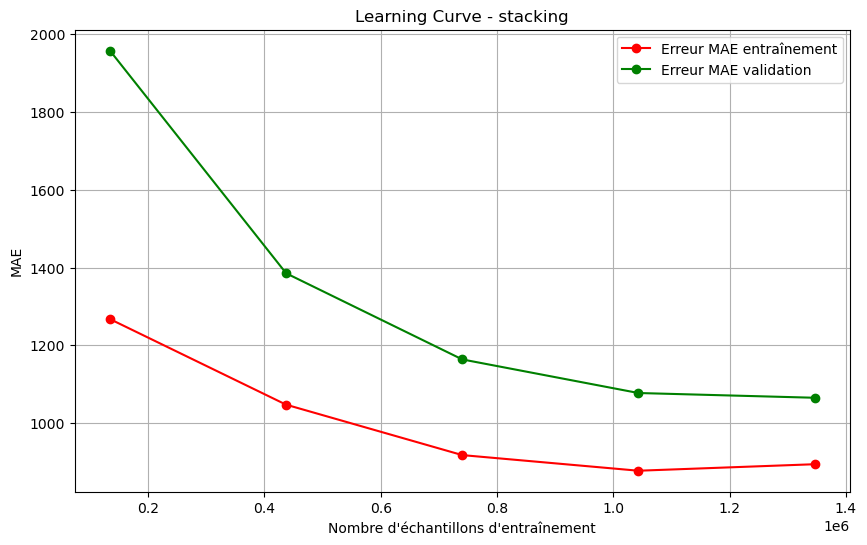

Modèle équilibré (Ratio MAE Test/Train = 1.12)
Modèle stacking.pkl sauvegardé
Temps (min) : 22.48


In [103]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor

bagging = BaggingRegressor(estimator=model, n_estimators=10, random_state=42)

train_and_evaluate_model(bagging, X_train, y_train, X_test, y_test, 'bagging')

models = [
    ("GradientBoosting", HistGradientBoostingRegressor(**best_params['GradientBoosting'])),
    ("XGBoost", XGBRegressor(**best_params['XGBoost']))
]

stacking = StackingRegressor(estimators=models, final_estimator=LinearRegression())
train_and_evaluate_model(stacking, X_train, y_train, X_test, y_test, 'stacking')


## Tests d'autres modèles
---

In [74]:
!pip install lightgbm catboost

0:	learn: 69808.9689113	test: 62954.5246843	best: 62954.5246843 (0)	total: 166ms	remaining: 2m 45s
100:	learn: 23824.4846213	test: 23764.1697811	best: 23764.1697811 (100)	total: 17.7s	remaining: 2m 37s
200:	learn: 19590.0994404	test: 20967.0371387	best: 20967.0371387 (200)	total: 34.9s	remaining: 2m 18s
300:	learn: 17278.5067358	test: 19459.8141117	best: 19459.8141117 (300)	total: 51.9s	remaining: 2m
400:	learn: 15647.3916378	test: 18541.3679763	best: 18541.3679763 (400)	total: 1m 9s	remaining: 1m 43s
500:	learn: 14469.9587263	test: 17967.8225413	best: 17967.6636076 (498)	total: 1m 26s	remaining: 1m 25s
600:	learn: 13455.4499898	test: 17551.8833076	best: 17551.4043112 (599)	total: 1m 43s	remaining: 1m 8s
700:	learn: 12648.9855962	test: 17263.6660800	best: 17263.6263660 (699)	total: 1m 59s	remaining: 51.1s
800:	learn: 12075.0128220	test: 17048.0508624	best: 17048.0508624 (800)	total: 2m 16s	remaining: 34s
900:	learn: 11509.9136668	test: 16866.7575804	best: 16865.0356906 (899)	total: 2m 

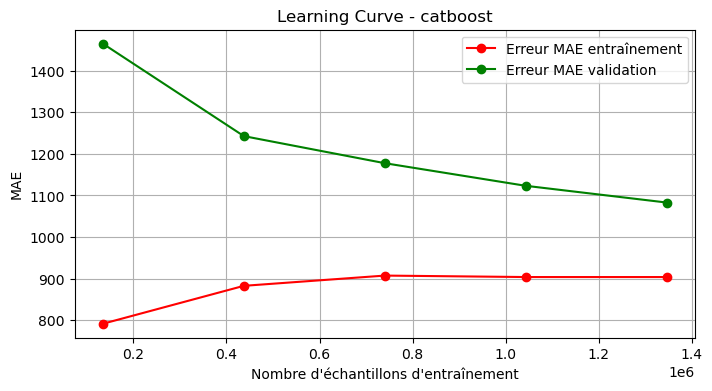

MAE: 974.7841793455226
RMSE: 16712.52987906085
R²: 0.934250736468181


In [35]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=1000, 
    learning_rate=0.05, 
    depth=8,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100,
    #task_type='GPU'
)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred_cat = cat_model.predict(X_test)

display_learning_curve(cat_model, 'catboost', X_train, y_train)

# Évaluation
print("MAE:", mean_absolute_error(y_test, y_pred_cat))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_cat)))
print("R²:", r2_score(y_test, y_pred_cat))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 1682449, number of used features: 31
[LightGBM] [Info] Start training from score 6761.353524

[Résultats lightgbm]
Train - MAE: 757.43 | RMSE: 11169.46 | R²: 0.9761
Test  - MAE: 894.20 | RMSE: 18589.37 | R²: 0.9187


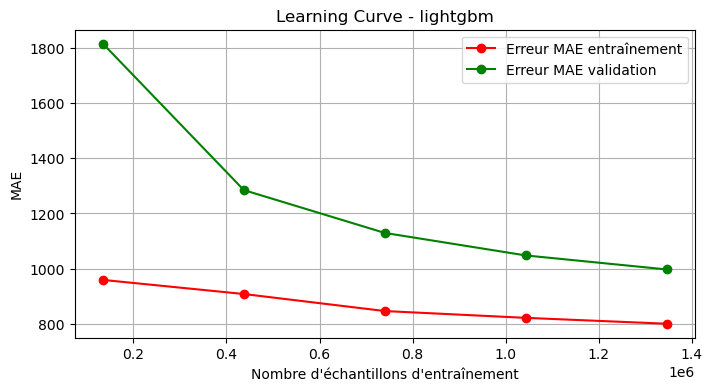

Modèle équilibré (Ratio MAE Test/Train = 1.18)
Modèle lightgbm.pkl sauvegardé
Temps (min) : 7.95


In [41]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    random_state=42
)

train_and_evaluate_model(lgb_model, X_train, y_train, X_test, y_test, 'lightgbm')

#### Voting Regressor


[Résultats Voting_CatBoost_LightGBM_XGBoost]
Train - MAE: 871.33 | RMSE: 14259.16 | R²: 0.9610
Test  - MAE: 931.01 | RMSE: 17923.62 | R²: 0.9244


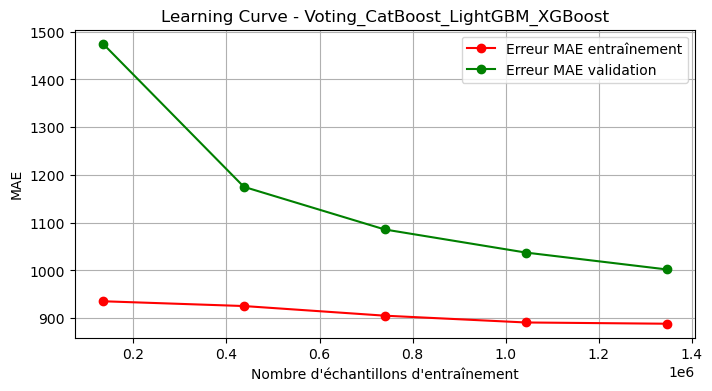

Modèle équilibré (Ratio MAE Test/Train = 1.07)
Modèle Voting_CatBoost_LightGBM_XGBoost.pkl sauvegardé
Temps (min) : 21.02


In [68]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

catboost = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_state=42
)

lightgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

xgboost = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

ensemble_model = VotingRegressor(
    estimators=[
        ('catboost', catboost),
        ('lightgbm', lightgbm),
        ('xgboost', xgboost)
    ],
    n_jobs=-1
)

train_and_evaluate_model(
    model=ensemble_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Voting_CatBoost_LightGBM_XGBoost"
)

## Deep Learning

### MLP

In [86]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6),
]

def display_scores(y_train, y_pred_train, y_test, y_pred_test, model_name):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)

    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)

    scores = pd.DataFrame([{
        'Modèle': model_name,
        'MAE Train': mae_train, 'MAE test': mae_test,
        'RMSE Train': rmse_train, 'RMSE Test': rmse_test,
        'R2 Train': r2_train, 'R2 Test': r2_test
    }])
    display(scores)

def plot_history(history, model_name):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history["loss"], label="Perte entraînement", color="r")
    plt.plot(history.history["val_loss"], label="Perte validation", color="g")
    plt.title(f"Courbe d'apprentissage - {model_name}")
    plt.xlabel("Époques")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.show();

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model_mlp = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

model_mlp.compile(optimizer="adam", loss="mse")
history = model_mlp.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/50
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - loss: 4160977664.0000 - val_loss: 2613641216.0000 - learning_rate: 0.0010
Epoch 2/50
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 83s 1ms/step - loss: 3005934592.0000 - val_loss: 2233175808.0000 - learning_rate: 0.0010
Epoch 3/50
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 59s 1ms/step - loss: 2839402752.0000 - val_loss: 2385163776.0000 - learning_rate: 0.0010
Epoch 4/50
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 60s 1ms/step - loss: 2721635840.0000 - val_loss: 2023706368.0000 - learning_rate: 0.0010
Epoch 5/50
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 59s 1ms/step - loss: 2773617664.0000 - val_loss: 1882303360.0000 - learning_rate: 0.0010
Epoch 6/50
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - loss: 3029059328.0000 - val_loss: 1785824128.0000 - learning_rate: 0.0010
Epoch 7/50
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 60s 1ms/step - loss: 4603615744.0000 - val_loss: 1711276800.0000 - learning_rate: 0.0010
Epoch 8/50
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 60s 1ms/step - loss: 2087

52577/52577 ━━━━━━━━━━━━━━━━━━━━ 31s 594us/step
13145/13145 ━━━━━━━━━━━━━━━━━━━━ 7s 563us/step


,Modèle,MAE Train,MAE test,RMSE Train,RMSE Test,R2 Train,R2 Test
0,MLP,2060.83951,2003.268778,35417.293283,33382.746608,0.7597,0.737668


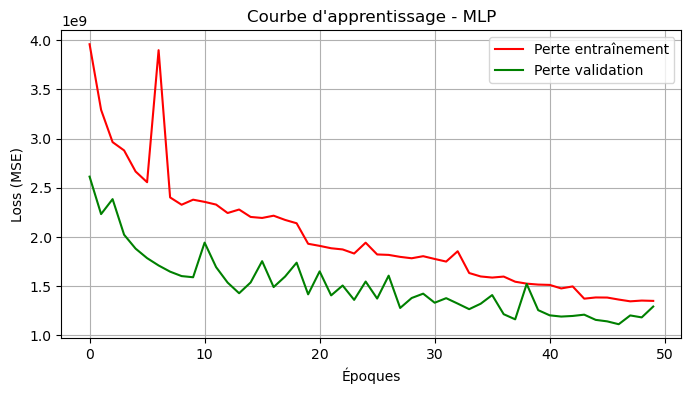

Modèle équilibré (Ratio MAE Test/Train = 0.96)


In [90]:
y_pred_train = model_mlp.predict(X_train).flatten()
y_pred_test = model_mlp.predict(X_test).flatten()

display_scores(y_train, y_pred_train, y_test, y_pred_test, 'MLP')

plot_history(history, 'MLP')

check_overfitting(mae_test, mae_train)

In [94]:
model_mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,317 (177.02 KB)

 Trainable params: 15,105 (59.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,212 (118.02 KB)

### Optimisation MLP

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

model_mlp_opt = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation="relu"),
    Dropout(0.1),
    Dense(256, activation="relu"),
    Dropout(0.1),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dropout(0.1),  
    Dense(32, activation="relu"),
    Dense(1)
])

model_mlp_opt.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
history_opt = model_mlp_opt.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/75
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step - loss: 3769129984.0000 - val_loss: 2313383936.0000 - learning_rate: 5.0000e-04
Epoch 2/75
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 133s 3ms/step - loss: 3261790976.0000 - val_loss: 1998702208.0000 - learning_rate: 5.0000e-04
Epoch 3/75
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 132s 3ms/step - loss: 2928093440.0000 - val_loss: 2794821376.0000 - learning_rate: 5.0000e-04
Epoch 4/75
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 130s 2ms/step - loss: 2884750848.0000 - val_loss: 1899942912.0000 - learning_rate: 5.0000e-04
Epoch 5/75
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 140s 2ms/step - loss: 3437202944.0000 - val_loss: 1914859904.0000 - learning_rate: 5.0000e-04
Epoch 6/75
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 128s 2ms/step - loss: 3006836224.0000 - val_loss: 1830384896.0000 - learning_rate: 5.0000e-04
Epoch 7/75
52577/52577 ━━━━━━━━━━━━━━━━━━━━ 129s 2ms/step - loss: 3068032000.0000 - val_loss: 2031735552.0000 - learning_rate: 5.0000e-04
Epoch 8/75
52577/52577 ━━━━━━━━━━━

52577/52577 ━━━━━━━━━━━━━━━━━━━━ 30s 569us/step
13145/13145 ━━━━━━━━━━━━━━━━━━━━ 8s 588us/step


,Modèle,MAE Train,MAE test,RMSE Train,RMSE Test,R2 Train,R2 Test
0,MLP optimisé,2312.071636,2232.100046,36790.455673,33704.551979,0.740705,0.732586



[Résultats MLP optimisé]
Train - MAE: 2312.07 | RMSE: 36790.46 | R²: 0.7407
Test  - MAE: 2232.10 | RMSE: 33704.55 | R²: 0.7326


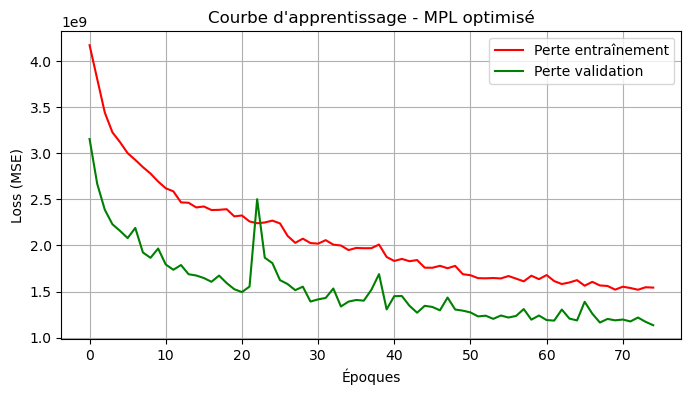

Modèle équilibré (Ratio MAE Test/Train = 0.96)


In [80]:
y_pred_train_opt = model_mlp_opt.predict(X_train).flatten()
y_pred_test_opt = model_mlp_opt.predict(X_test).flatten()

display_scores(y_train, y_pred_train_opt, y_test, y_pred_test_opt, 'MLP optimisé')

plot_history(history_opt, 'MLP optimisé')

check_overfitting(mae_test, mae_train)

In [96]:
model_mlp_opt.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 512)                 │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 580,613 (2.21 MB)

 Trainable params: 193,537 (756.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 387,076 (1.48 MB)